In [21]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from bertopic import BERTopic
import seaborn as sns
from evaluation import Trainer, DataLoader
from sentence_transformers import SentenceTransformer
import glob

In [ ]:
sentences = ["This is an example sentence", "Each sentence is converted"]
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2", output_hidden_states=True)
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [ ]:
def cls_pooling(hidden_states, layer_number):
    return hidden_states[layer_number][:, 0, :]

def mean_pooling(hidden_states, layer_number, attention_mask):
    token_embeddings = hidden_states[
        layer_number
    ]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

def max_pooling(hidden_states, layer_number, attention_mask):
    token_embeddings = hidden_states[layer_number]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    max_embeddings = torch.max(token_embeddings, 1)[0]
    return max_embeddings

In [ ]:
def get_embedding_from_layer(
    model_output,
    layer_number,
    attention_mask=None,
    pooling="cls",
):
    hidden_states = model_output["hidden_states"]
    
    if pooling == "cls":
        return cls_pooling(hidden_states, layer_number)
    
    elif pooling == "mean":
        assert attention_mask != None, "Please provide attention mask if you are using mean pooling"
        return mean_pooling(hidden_states, layer_number, attention_mask)
    
    elif pooling == "max":
        assert attention_mask != None, "Please provide attention mask if you are using max pooling"
        return max_pooling(hidden_states, layer_number, attention_mask)
    
    else:
        raise ValueError("Wrong pooling method provided in the function call")
        

In [ ]:
def get_embedding_layer_output(model_output, attention_mask=None, pooling="cls"):
    return get_embedding_from_layer(model_output, 0, attention_mask, pooling).numpy()


def get_last_hidden_layer_output(model_output, attention_mask=None, pooling="cls"):
    return get_embedding_from_layer(model_output, -1, attention_mask, pooling).numpy()


def get_sum_all_layers(model_output, attention_mask=None, pooling="cls"):
    outputs = []
    for l in range(np.shape(model_output["hidden_states"])[0]):
        output = get_embedding_from_layer(model_output, l, attention_mask, pooling)
        outputs.append(output.numpy())
    return sum(outputs)


def get_second_last_layer_output(model_output, attention_mask=None, pooling="cls"):
    return get_embedding_from_layer(model_output, -2, attention_mask, pooling).numpy()


def get_sum_last_four_layers(model_output, attention_mask=None, pooling="cls"):
    outputs = []
    layers = [-4, -3, -2, -1]
    for layer in layers:
        output = get_embedding_from_layer(model_output, layer, attention_mask, pooling)
        outputs.append(output.numpy())
    return sum(outputs)


def get_concat_last_four_layers(model_output, attention_mask=None, pooling="cls"):
    outputs = []
    layers = [-4, -3, -2, -1]
    for layer in layers:
        output = get_embedding_from_layer(model_output, layer, attention_mask, pooling)
        outputs.append(output)
    return torch.cat(outputs, dim=-1).numpy()


Think about normalizing embedding

In [ ]:
np.min(model_output.last_hidden_state[:, 0, :].numpy())

In [ ]:
np.max(model_output.last_hidden_state[:, 0, :].numpy())

<h2> Evaluation <h2>

In [ ]:
class Pooling:
    def __init__(self, pooling_type):
        self.pooling_type = pooling_type

    def __call__(self, hidden_states, layer_number, attention_mask=None):
        if self.pooling_type == "cls":
            return hidden_states[layer_number][:, 0, :]
        elif self.pooling_type == "mean":
            token_embeddings = hidden_states[
                layer_number
            ]  # First element of model_output contains all token embeddings
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
                input_mask_expanded.sum(1), min=1e-9
            )
        elif self.pooling_type == "max":
            token_embeddings = hidden_states[layer_number]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
            max_embeddings = torch.max(token_embeddings, 1)[0]
            return max_embeddings
        else:
            raise ValueError("Wrong pooling method provided in the Pooler initialization")

In [ ]:
class EmbeddingsRetriever:
    def __init__(self, embedding_model, tokenizer):
        self.embedding_model = embedding_model
        self.tokenizer = tokenizer
        self.functions = [self.get_embedding_layer_output, 
                          self.get_embedding_last_hidden_layer, 
                          self.get_embedding_sum_all_layers, 
                          self.get_embedding_second_last_layer, 
                          self.get_embedding_sum_last_four_layers, 
                          self.get_embedding_concat_last_four_layers]

    def tokenize_and_produce_model_output(self, data):
        encoded_input = self.tokenizer(data, padding=True, truncation=True, return_tensors="pt")
        self.attention_mask = encoded_input["attention_mask"]
        with torch.no_grad():
            self.model_output = self.embedding_model(**encoded_input)

    def get_embedding_from_layer(self, layer_number, pooling="cls"):
        hidden_states = self.model_output["hidden_states"]
        if pooling == "cls":
            pooler = Pooling("cls")
            return pooler(hidden_states, layer_number)

        elif pooling == "mean":
            assert self.attention_mask != None, "Please provide attention mask if you are using mean pooling"
            pooler = Pooling("mean")
            return pooler(hidden_states, layer_number, self.attention_mask)

        elif pooling == "max":
            assert self.attention_mask != None, "Please provide attention mask if you are using max pooling"
            pooler = Pooling("max")
            return pooler(hidden_states, layer_number, self.attention_mask)

        else:
            raise ValueError("Wrong pooling method provided in the function call")

    def get_embedding_layer_output(self, pooling="cls"):
        return self.get_embedding_from_layer(0, pooling).numpy()

    def get_embedding_last_hidden_layer(self, pooling="cls"):
        return self.get_embedding_from_layer(-1, pooling).numpy()

    def get_embedding_sum_all_layers(self, pooling="cls"):
        outputs = []
        for layer in range(np.shape(self.model_output["hidden_states"])[0]):
            output = self.get_embedding_from_layer(layer, pooling)
            outputs.append(output.numpy())
        return sum(outputs)

    def get_embedding_second_last_layer(self, pooling="cls"):
        return self.get_embedding_from_layer(-2, pooling).numpy()

    def get_embedding_sum_last_four_layers(self, pooling="cls"):
        outputs = []
        layers = [-4, -3, -2, -1]
        for layer in layers:
            output = self.get_embedding_from_layer(layer, pooling)
            outputs.append(output.numpy())
        return sum(outputs)

    def get_embedding_concat_last_four_layers(self, pooling="cls"):
        outputs = []
        layers = [-4, -3, -2, -1]
        for layer in layers:
            output = self.get_embedding_from_layer(layer, pooling)
            outputs.append(output)
        return torch.cat(outputs, dim=-1).numpy()

In [ ]:
dataset = pd.read_csv("./data/tweets.csv")
dataloader = (
    DataLoader(dataset="trump").prepare_docs(save="trump.txt").preprocess_octis(output_folder="trump")
)

In [ ]:
# Prepare data
dataset, custom = "trump", True
data_loader = DataLoader(dataset)
_, timestamps = data_loader.load_docs()
data = data_loader.load_octis(custom)
data = [" ".join(words) for words in data.get_corpus()]

# Extract embeddings
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2", output_hidden_states=True)

embedder = EmbeddingsRetriever(model, tokenizer)
embedder.tokenize_and_produce_model_output(data)

In [ ]:
poolings = ["mean", "cls", "max"]

In [ ]:
for pooling in poolings:
    for function in embedder.functions:
        for i in range(3):
            params = {
                "embedding_model": "all-MiniLM-L12-v2",
                "nr_topics": [(i + 1) * 10 for i in range(5)],
                "min_topic_size": 15,
                "verbose": True,
            }
            embeddings = function(pooling=pooling)
            trainer = Trainer(
                dataset=dataset,
                model_name="BERTopic",
                params=params,
                bt_embeddings=embeddings,
                custom_dataset=custom,
                verbose=True,
            )
            results = trainer.train(save=f"./results/BERTopic_trump_{'_'.join(function.__name__.split('_')[1:])}_{pooling}_{i+1}")

<h3> Analyzing results <h3>

In [22]:
files_list = glob.glob("./results/*.json")

In [30]:
test = files_list[0]
"_".join(test.split("_")[3:-1]) + "_pooling"

'sum_all_layers_max_pooling'

In [31]:
dfs = []
for f in files_list:
    embedding_retrieval_type = "_".join(f.split("_")[3:-1]) + "_pooling"
    df = pd.read_json(f)
    df["embedding_retrieval_type"] = embedding_retrieval_type
    dfs.append(df)

In [34]:
full_results = pd.concat(dfs)

In [42]:
keys_to_extract = ["embedding_model", "nr_topics", "min_topic_size"]
for key in keys_to_extract:
    full_results[key] = full_results["Params"].apply(lambda x: x.get(key, None))
full_results.drop("Params", axis=1, inplace=True)

In [43]:
keys_to_extract = ["npmi", "diversity"]
for key in keys_to_extract:
    full_results[key] = full_results["Scores"].apply(lambda x: x.get(key, None))
full_results.drop("Scores", axis=1, inplace=True)

In [49]:
set(full_results["embedding_retrieval_type"])

{'concat_last_four_layers_cls_pooling',
 'concat_last_four_layers_max_pooling',
 'concat_last_four_layers_mean_pooling',
 'last_hidden_layer_cls_pooling',
 'last_hidden_layer_max_pooling',
 'last_hidden_layer_mean_pooling',
 'layer_output_cls_pooling',
 'layer_output_max_pooling',
 'layer_output_mean_pooling',
 'second_last_layer_cls_pooling',
 'second_last_layer_max_pooling',
 'second_last_layer_mean_pooling',
 'sum_all_layers_cls_pooling',
 'sum_all_layers_max_pooling',
 'sum_all_layers_mean_pooling',
 'sum_last_four_layers_cls_pooling',
 'sum_last_four_layers_max_pooling',
 'sum_last_four_layers_mean_pooling'}

In [59]:
full_results

,Dataset,Dataset Size,Model,Computation Time,embedding_retrieval_type,embedding_model,nr_topics,min_topic_size,npmi,diversity
0,trump,1520,BERTopic,5.424000,sum_all_layers_max_pooling,all-MiniLM-L12-v2,10,15,-0.076811,1.000000
1,trump,1520,BERTopic,5.126191,sum_all_layers_max_pooling,all-MiniLM-L12-v2,20,15,-0.178772,0.766667
2,trump,1520,BERTopic,5.751441,sum_all_layers_max_pooling,all-MiniLM-L12-v2,30,15,-0.196533,0.825000
3,trump,1520,BERTopic,5.140256,sum_all_layers_max_pooling,all-MiniLM-L12-v2,40,15,-0.068224,0.966667
4,trump,1520,BERTopic,5.212994,sum_all_layers_max_pooling,all-MiniLM-L12-v2,50,15,-0.178772,0.766667
...,...,...,...,...,...,...,...,...,...,...
0,trump,1520,BERTopic,5.609215,last_hidden_layer_mean_pooling,all-MiniLM-L12-v2,10,15,-0.031122,0.775000
1,trump,1520,BERTopic,5.520285,last_hidden_layer_mean_pooling,all-MiniLM-L12-v2,20,15,-0.031122,0.775000
2,trump,1520,BERTopic,5.880328,last_hidden_layer_mean_pooling,all-MiniLM-L12-v2,30,15,-0.020166,0.682353
3,trump,1520,BERTopic,5.592904,last_hidden_layer_mean_pooling,all-MiniLM-L12-v2,40,15,-0.043904,0.775000


In [90]:
results_grouped = full_results.groupby([full_results["embedding_retrieval_type"], full_results["nr_topics"]], as_index=False)[["nr_topics", "npmi", "diversity", "Computation Time"]].mean()

<Axes: xlabel='nr_topics', ylabel='npmi'>

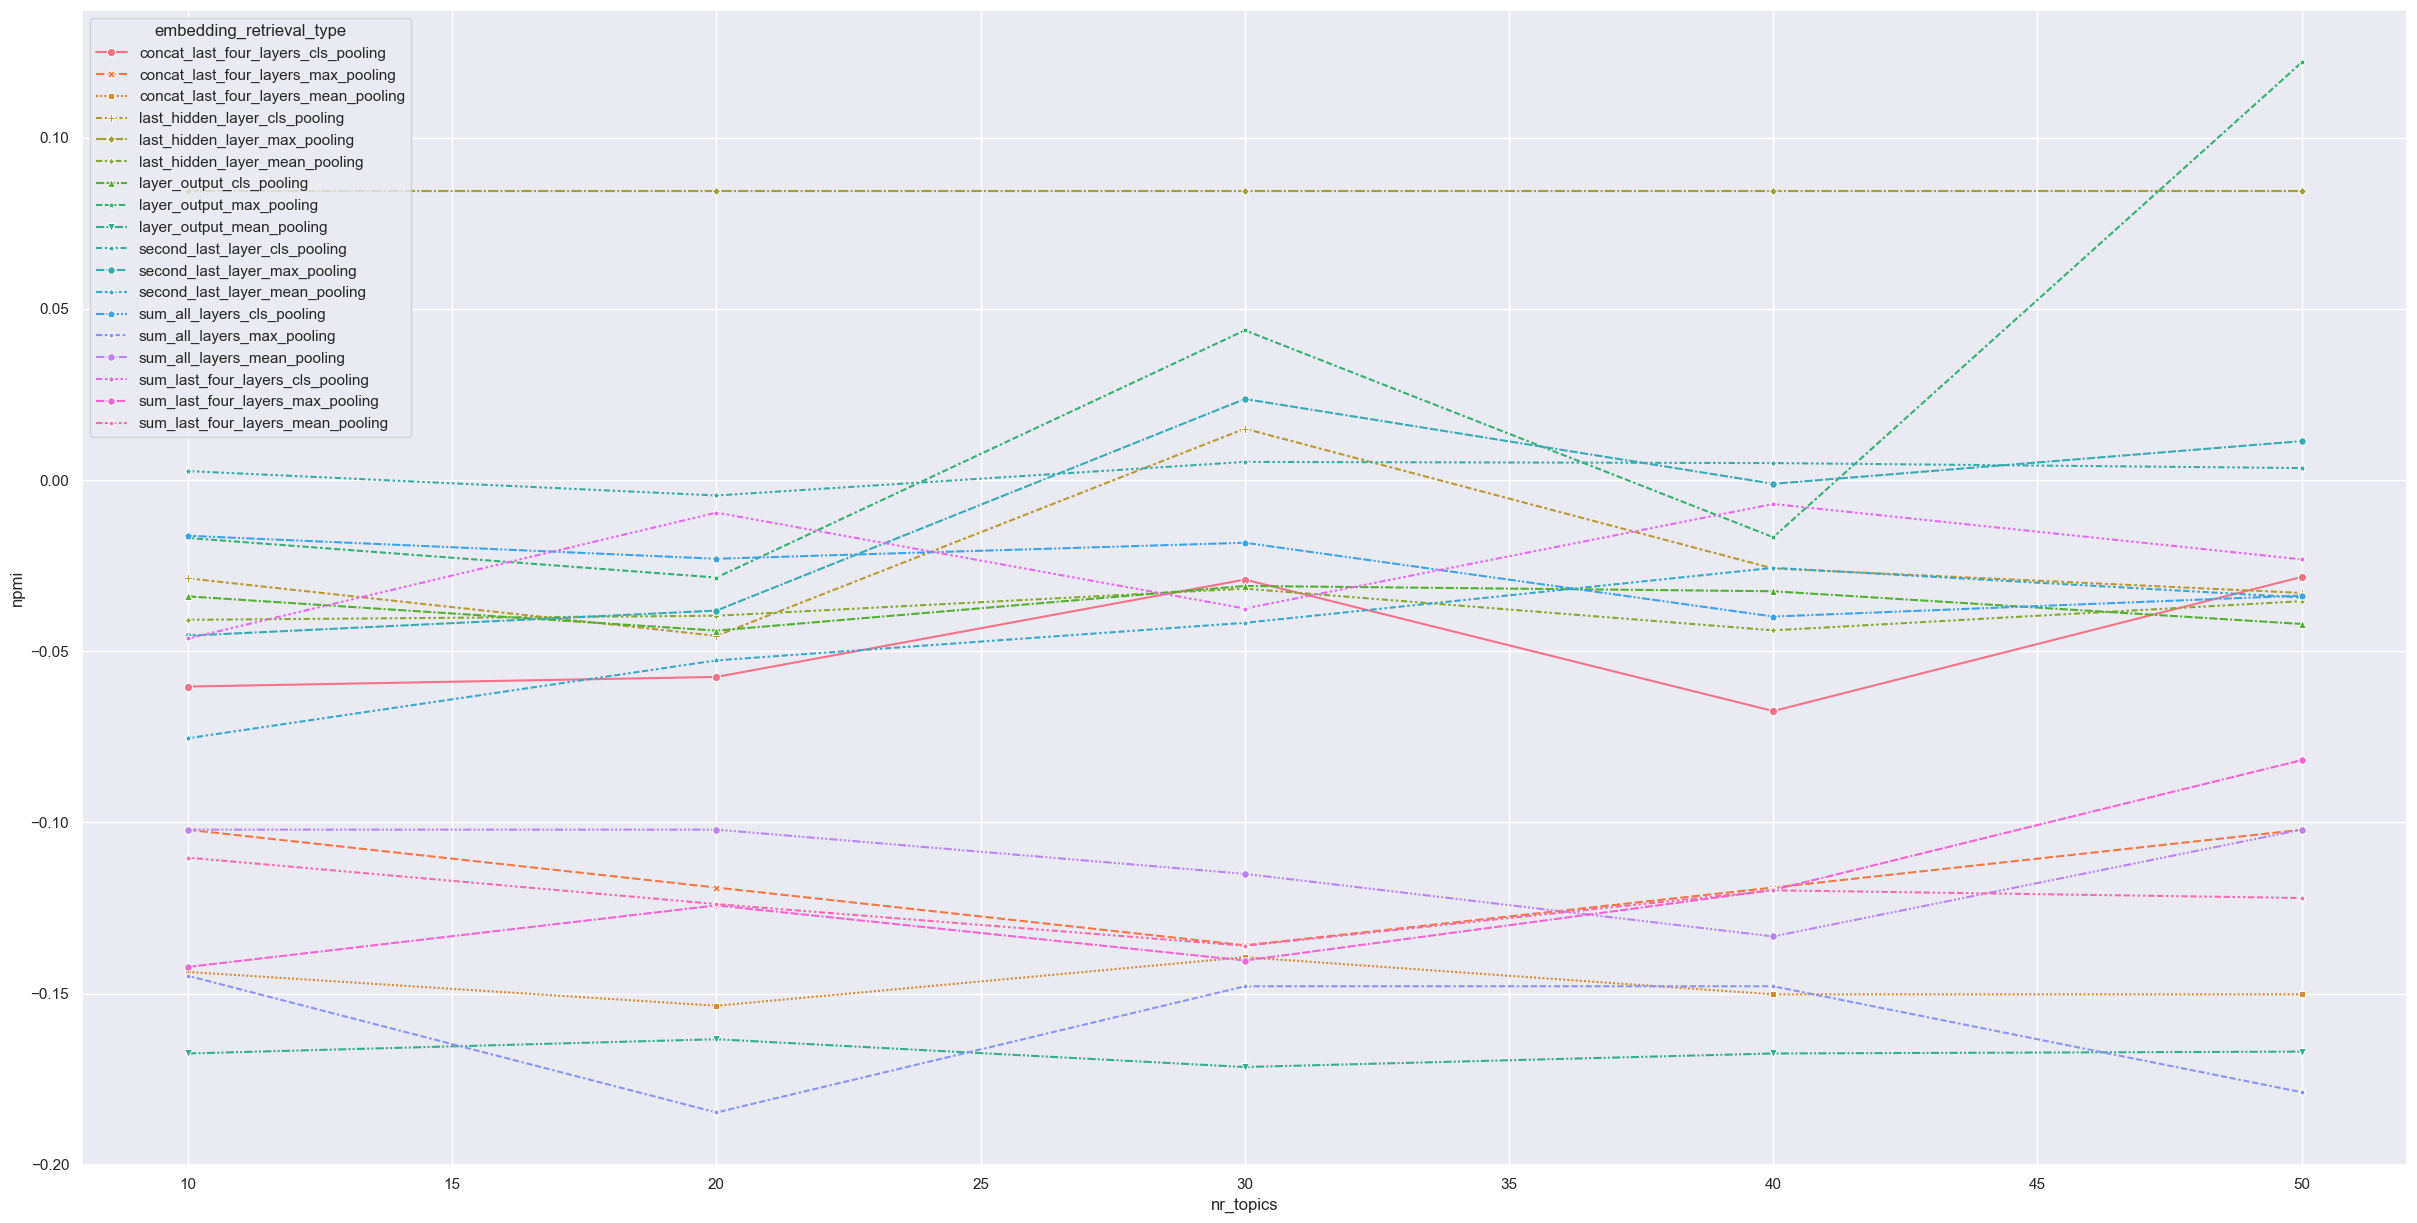

In [100]:
import seaborn as sns

sns.set(rc={"figure.figsize": (30, 15)})

sns.lineplot(
    data=results_grouped, 
    x="nr_topics", 
    y="npmi", 
    hue="embedding_retrieval_type", 
    style="embedding_retrieval_type", 
    markers=True, 
)

<Axes: xlabel='nr_topics', ylabel='diversity'>

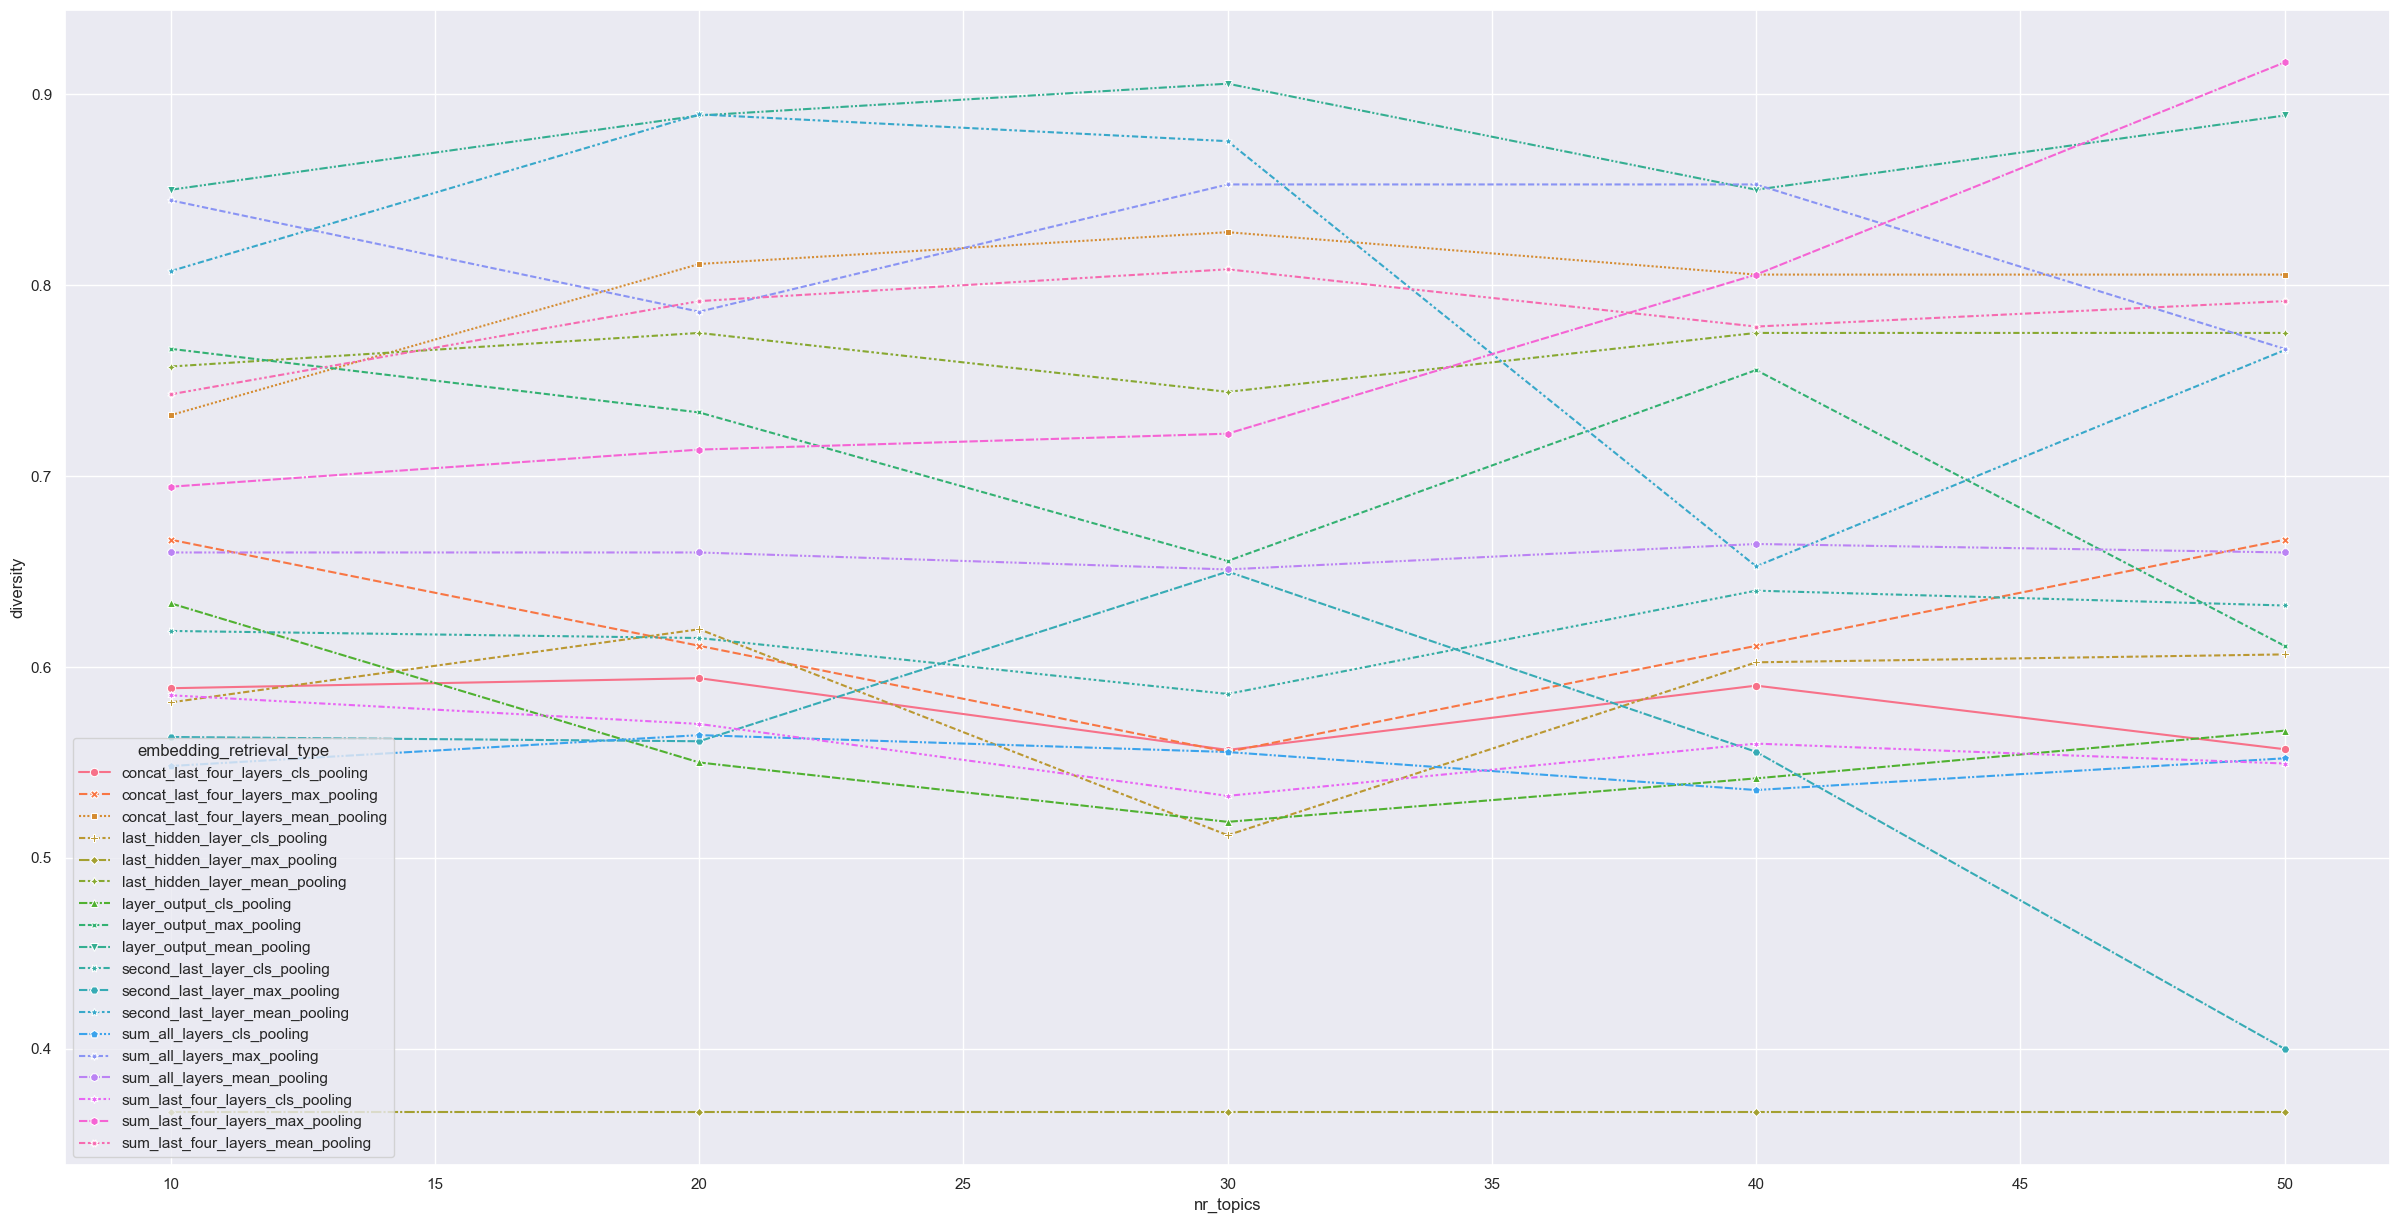

In [101]:
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="diversity",
    hue="embedding_retrieval_type",
    style="embedding_retrieval_type",
    markers=True,
)